# Setting up

In [1]:
# Google Colab environment: It is required for the user to have a Google Drive account!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing all the necessary Python libraries

%pip install h5py==2.10.0
%pip install heartpy==1.2.7
%pip install wfdb==3.4.0
# !git clone https://github.com/MIT-LCP/wfdb-python
# %cd wfdb-python
%pip install kapre==0.3.5
%pip install tensorflow-gpu==2.4.1
%pip install natsort==7.1.1
%pip install pandas==1.3.1
%pip install matplotlib==3.1.3
%pip install scikit-learn==0.24.2
%pip install numpy==1.18.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 4.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for kapre: filename=kapre-0.3.5-py3-none-any.whl size=27550 sha256=f366cbd15e8979a13d5eb6e332ab38b56f95c966bd77b4dbbbc776a46c179914
  Stored in dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: natsort
    Found existing installation: natsort 5.5.0
    Uninstalling natsort-5.5.0:
      Successfully uninstalled natsort-5.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.2 MB/s 
  Attemptin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 3.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.1 MB 4.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the pack

In [ ]:
# Details on the GPU used for training the Deep Learning models: Also mentioned in the FYP Final Report

!nvidia-smi

Mon Jun 20 09:04:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading the MIMIC I records

In [ ]:
""" 
This code cell performs the following tasks:

-----> Downloads the MIMIC I records from the Physionet website (see https://physionet.org/content/mimicdb/1.0.0/)
-----> Extracts Photoplethysmography (PPG) and Arterial Blood Pressure (ABP) signal data
-----> Performs peak detection on the ABP (systolic and diastolic peaks of the ABP signals to generate SBP and DBP values as ground truth) and PPG signals. 
-----> ABP and PPG signals as well as the detected peaks are stored in .h5 files.

Required input: RecordsFile -----> .txt file of all of the top-level folder 
                                    names you require (see Github repository 
                                    for the .txt. file used)

Required output: OutputPath -----> Create an empty folder! Folder to hold all 
                                   the .h5 files produced from the 
                                   download_mimic_records function
"""

from os.path import expanduser, join, isdir
from os import mkdir
from itertools import compress
import datetime
import wfdb
import numpy as np
import heartpy as hp
import h5py
import matplotlib.pyplot as plt

# helper function to find minima between two maxima
def find_minima(sig, pks, fs):
    min_pks = []
    for i in range(0,len(pks)):
        pks_curr = pks[i]
        if i == len(pks)-1:
            pks_next = len(sig)
        else:
            pks_next = pks[i+1]

        sig_win = sig[pks_curr:pks_next]

        if len(sig_win) < 1.5*fs:
            min_pks.append(np.argmin(sig_win) + pks_curr)

    return min_pks

def download_mimic_records(RecordsFile, OutputPath):

    # load record names from text file
    with open(RecordsFile, 'r') as f:
        RecordFiles = f.read()
        RecordFiles = RecordFiles.split("\n")
        RecordFiles = RecordFiles[:-1]

    k = 1
 #   allVals = [465, 86, 224, 130, 248, 292, 164, 157, 164, 8, 143, 282, 277, 192, 114, 256, 256, 183, 205, 169, 255, 255, 79, 349, 64, 255, 151, 256, 134, 290, 260, 141, 274, 151, 73, 163, 351, 312, 291, 312, 279, 211, 307, 324, 168, 256, 187, 202, 280, 257, 283, 412, 376, 52, 231, 106, 180, 117, 258, 252, 264]
    subsetVals = [248, 292, 277, 114, 256, 73, 163, 283, 412, 106, 180, 117]

    for count, file in enumerate(RecordFiles):

      print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing record {file}')

      for i in range(1,subsetVals[count]+1):

        if i < 10:
          fileName = '{0}0000{1}'.format(file, i)
        elif i < 100:
          fileName = '{0}000{1}'.format(file, i)
        else:
          fileName = '{0}00{1}'.format(file, i)

        print(fileName)
        record = wfdb.rdrecord(fileName, pn_dir='mimicdb/' + file) 

        # check, if ABP and PLETH are present in the record. If not, continue with next record
        if 'PLETH' in record.sig_name:
            pleth_idx = record.sig_name.index('PLETH')
            ppg = record.p_signal[:,pleth_idx]
            fs = record.fs
         #   recordTemp1 = wfdb.rdrecord(fileName, pn_dir='mimicdb/' + file + '/',  channels = [record.sig_name.index('PLETH')])
        else:
            continue

        if 'ABP' in record.sig_name:
            abp_idx = record.sig_name.index('ABP')
            abp = record.p_signal[:,abp_idx]
        #    recordTemp2 = wfdb.rdrecord(fileName, pn_dir='mimicdb/' + file + '/',  channels = [record.sig_name.index('ABP')]) # sampfrom=0, sampto=7200,
        else:
            continue

        # detect systolic and diastolic peaks using heartpy
        try:
            abp_FidPoints = hp.process(abp, fs)
        except hp.exceptions.BadSignalWarning:
            continue

        ValidPks = abp_FidPoints[0]['binary_peaklist']
        abp_sys_pks = abp_FidPoints[0]['peaklist']
        abp_sys_pks = list(compress(abp_sys_pks, ValidPks == 1))
        abp_dia_pks = find_minima(abp, abp_sys_pks, fs)


        try:
          ppg_FidPoints = hp.process(ppg, fs)
        except hp.exceptions.BadSignalWarning:
            continue

        ValidPks = ppg_FidPoints[0]['binary_peaklist']
        ppg_pks = ppg_FidPoints[0]['peaklist']
        ppg_pks = list(compress(ppg_pks, ValidPks == 1))
        ppg_onset_pks = find_minima(ppg, ppg_pks, fs)

      #   x1a = np.linspace(0, len(abp)- 1, len(abp))
      #   x1a /= fs
      #   plt.figure(k, figsize=(25, 5))
      #   plt.plot(x1a, abp)
      #  # abpVals.append(abp)
      #  # ppgVals.append(ppg)
      #   plt.plot((np.asarray(abp_sys_pks))/fs, abp[(np.asarray(abp_sys_pks))], 'rx', marker='x', color='#8b0000', label='Systolic', markersize=12)   # np.asarray(abp_sys_pks)
      #   plt.plot((np.asarray(abp_dia_pks))/fs, ppg[(np.asarray(abp_dia_pks))], 'rx', marker='x', color='g', label='Diastolic', markersize=12)
      #   plt.xlim(0.0, 60.0)
      #   plt.title('ABP for Patient ' + fileName)
      #   plt.xlabel("Time (Seconds)")
      #   plt.ylabel("ABP (mmHg)")
      #   plt.legend(['ABP', 'Systolic', 'Diastolic'], loc='upper right', fontsize=15)        
      #   x2a = np.linspace(0, len(ppg)- 1, len(ppg))
      #   x2a /= fs      
      #   k = k + 1
      #   plt.figure(k, figsize=(25, 5))
      #   plt.plot(x2a, ppg)
      #   plt.plot((np.asarray(ppg_pks))/fs, ppg[(np.asarray(ppg_pks))], 'rx', marker='x', color='#8b0000', label='Systolic', markersize=12)
      #   plt.plot((np.asarray(ppg_onset_pks))/fs, ppg[(np.asarray(ppg_onset_pks))], 'rx', marker='x', color='g', label='Diastolic', markersize=12)
      #   plt.xlim(0.0, 60.0)
      #   plt.title('PPG for Patient ' + fileName)
      #   plt.xlabel("Time (Seconds)")
      #   plt.ylabel("PPG (mV)")
      #   plt.legend(['PPG', 'Systolic', 'Diastolic'], loc='upper right', fontsize=15)
      #   k = k + 1

        # save ABP and PPG signals as well as detected peaks in a .h5 file
        SubjectName = fileName
        SubjectFolder = join(join(OutputPath, SubjectName))
        if not isdir(SubjectFolder):
            mkdir(SubjectFolder)
        
        # abpSys.append(np.array(abp_sys_pks))
        # ppgSys.append(np.array(ppg_pks))

        with h5py.File(join(SubjectFolder, fileName + ".h5"),'w') as f:
            signals = np.concatenate((abp[:,np.newaxis],ppg[:,np.newaxis]), axis=1)
            f.create_dataset('val', signals.shape, data=signals)
            f.create_dataset('nB2', (1,len(ppg_onset_pks)), data=ppg_onset_pks)
            f.create_dataset('nA2', (1,len(ppg_pks)), data=ppg_pks)
            f.create_dataset('nB3', (1,len(abp_dia_pks)), data=abp_dia_pks)
            f.create_dataset('nA3', (1,len(abp_sys_pks)), data=abp_sys_pks)
    
  #  abpVals = np.array(abpVals)
  #  ppgVals = np.array(ppgVals)

    # abpSys = np.array(abpSys)
    # ppgSys = np.array(ppgSys)
    print('script finished')
#    return abpVals, ppgVals

if __name__ == '__main__':
    RecordsFile = '/content/drive/MyDrive/MIMIC_ppg_dataset_records_final.txt'
    OutputPath = '/content/drive/MyDrive/Colab Notebooks/FilesFinal'
    download_mimic_records(RecordsFile, OutputPath)

06/20/2022, 15:57:23: Processing record 477
47700001
47700002
47700003
47700004
47700005
47700006
47700007
47700008
47700009
47700010
47700011
47700012
47700013
47700014
47700015
47700016
47700017
47700018
47700019
47700020
47700021
47700022
47700023
47700024
47700025
47700026
47700027
47700028
47700029
47700030
47700031
47700032
47700033
47700034
47700035
47700036
47700037
47700038
47700039
47700040
47700041
47700042
47700043
47700044
47700045
47700046
47700047
47700048
47700049
47700050
47700051
47700052
47700053
47700054
47700055
47700056
47700057
47700058
47700059
47700060
47700061
47700062
47700063
47700064
47700065
47700066
47700067
47700068
47700069
47700070
47700071
47700072


/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


47700073
47700074
47700075
47700076
47700077
47700078
47700079
47700080
47700081
47700082
47700083
47700084
47700085
47700086
47700087
47700088
47700089
47700090
47700091
47700092
47700093
47700094
47700095
47700096
47700097
47700098
47700099
47700100
47700101
47700102
47700103
47700104
47700105
47700106
47700107


/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


47700108
47700109
47700110
47700111
47700112
47700113
47700114
47700115
47700116
47700117
47700118
47700119
47700120
47700121
47700122
47700123
47700124
47700125
47700126
47700127
47700128
47700129
47700130
47700131
47700132
47700133
47700134
47700135
47700136
47700137
47700138
47700139
47700140
47700141
47700142
47700143
47700144
47700145
47700146
47700147
47700148
47700149
47700150
47700151
47700152
47700153
47700154
47700155
47700156
47700157
47700158
47700159
47700160
47700161
47700162
47700163
47700164
47700165
47700166
47700167
47700168
47700169
47700170
47700171
47700172
47700173
47700174
47700175
47700176
47700177
47700178
47700179
47700180
06/20/2022, 16:15:44: Processing record 480
48000001
48000002
48000003
48000004
48000005
48000006
48000007
48000008
48000009
48000010
48000011
48000012
48000013
48000014
48000015
48000016
48000017
48000018
48000019
48000020
48000021
48000022
48000023
48000024
48000025
48000026
48000027
48000028
48000029
48000030
48000031
48000032
48000033
48

# Preparing the MIMIC I dataset

In [ ]:
"""
This code cell performs the following tasks:

-----> Preprocesses the downloaded PPG data
-----> ABP and PPG signals are divided into windows of a defined length and overlap
-----> Ground truth SBP and DBP values are extracted from the ABP signals
-----> PPG signals are filtered
-----> Different plausibility and sanity checks are performed to exclude artifacts from the dataset
-----> PPG signal windows and associated SBP/DBP value pairs are stored in a .h5 file.

Required input:  DataPath ----->   Path to folder which holds all 
                                   the .h5 files produced from the 
                                   download_mimic_records function

Required output: OutputPath -----> Path which creates a new .h5 file 
                                   which holds the pre-processed
                                   ABP and PPG data

"""

from os.path import join, expanduser, isfile, splitext
from os import listdir, scandir
from random import shuffle
import datetime
import matplotlib.pyplot as plt
import h5py
import numpy as np
import wfdb
from scipy.signal import butter, freqs, filtfilt, find_peaks
from sklearn.covariance import EllipticEnvelope

plt.rcParams.update({'figure.max_open_warning': 0})


def CreateWindows(win_len, fs, N_samp, overlap):
    win_len = win_len * fs
    overlap = np.round(overlap*win_len)
    N_samp = N_samp - win_len + 1

    idx_start = np.round(np.arange(0,N_samp, win_len-overlap)).astype(int)
    idx_stop = np.round(idx_start + win_len - 1)

    return idx_start, idx_stop

def prepare_MIMIC_dataset(DataPath, OutputFile, NsampPerSubMax:int=None, NsampMax:int=None, win_len:int=7, win_overlap:float=0.5, savePPGData=False):

    if savePPGData == False:
        print("Saving BP data only")
    else:
        print("saving BP & PPG data")

    RecordsFile = splitext(OutputFile)[0] + '_records.txt'
    SubjectDirs = scandir(DataPath)
    NumSubjects = sum(1 for x in SubjectDirs)
    SubjectDirs = scandir(DataPath)

    fs = 125

    SBP_min = 60;
    SBP_max = 210;
    DBP_min = 30;
    DBP_max = 140;  # threshold of +30 mmHg either side of the most serious heart condition values

    # 4th order butterworth filter for PPG preprocessing
    b,a = butter(4,[0.5, 40], 'bandpass', fs=fs)

    # if output file does not exist already, create it
    if not isfile(OutputFile):
        with h5py.File(OutputFile, "a") as f:
            if savePPGData:
                f.create_dataset('ppg', (0,win_len*fs), maxshape=(None,win_len*fs), chunks=(100, win_len*fs))
            f.create_dataset('label', (0,2), maxshape=(None,2), dtype=int, chunks=(100,2))
            f.create_dataset('subject_idx', (0,1), maxshape=(None,1), dtype=int, chunks=(100,1))

        with open(RecordsFile,'w') as f:
            pass

 #   abp1 = []
  #  abp2 = []
    # loop over all subjects and their files in the source folder
    subjectID = 0
    k = 1
    for idx, dirs in enumerate(SubjectDirs):
        print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing subject {idx+1} of {NumSubjects} ({dirs.name}): ', end='')

        PPG_RECORD = np.empty((0, win_len * fs))
        OUTPUT = np.empty((0, 2))

        DataFiles = [f for f in listdir(join(DataPath,dirs)) if isfile(join(DataPath, dirs,f)) and f.endswith('.h5')]
        shuffle(DataFiles)

        N_samp_total = 0
        for idx, file in enumerate(DataFiles):
            try:
                with h5py.File(join(DataPath, dirs, file), "r") as f:
                    data = {}
                    for key in f.keys():
                        data[key] = np.array(f[key]).transpose()
            except TypeError:
                print("could not read file. Skipping.")
            if savePPGData:
                PPG = data['val'][1, :]

            ABP = data['val'][0, :]

            if 'nB2' not in data:
                continue

            sys_p = data['nA2']

            ABP_sys_idx = data['nA3']-1
            ABP_dia_idx = data['nB3']-1

            # create start and stop indizes for time windows
            N_samples = ABP.shape[0]
            win_start, win_stop = CreateWindows(win_len, fs, N_samples, win_overlap)
            N_win = len(win_start)
            N_samp_total += N_win

            if savePPGData:
                ppg_record = np.zeros((N_win, win_len*fs))
                ppg_peaks = []

            output = np.zeros((N_win, 2))

            # loop over windows


            for i in range(0, N_win):
                idx_start = win_start[i]
                idx_stop = win_stop[i]

                # extract peak idx of the current windows and the corresponding ABP signal values
                peak_idx = np.where(np.logical_and(sys_p >= idx_start, sys_p < idx_stop))
                sys_p_win = sys_p[peak_idx]
                N_sys_p = len(sys_p_win)

                # check if HR is in a plausible range
                if N_sys_p < (win_len/60)*40 or N_sys_p > (win_len/60)*120:
                    output[i,:] = np.nan
                    continue

                if savePPGData:
                    ppg_win = PPG[idx_start:idx_stop+1]

                # extract ABP window and fiducial points systolic and diastolic blood pressure
                abp_win = ABP[idx_start:idx_stop+1]

                # sanity check if enough peak values are present and if the number of SBP peaks matches the number of
                # DBP peaks
                ABP_sys_idx_win = ABP_sys_idx[np.logical_and(ABP_sys_idx >= idx_start, ABP_sys_idx < idx_stop)].astype(int)
                ABP_dia_idx_win = ABP_dia_idx[np.logical_and(ABP_dia_idx >= idx_start, ABP_dia_idx < idx_stop)].astype(int)

                if ABP_sys_idx_win.shape[-1] < (win_len/60)*40 or ABP_sys_idx_win.shape[-1] > (win_len/60)*120:
                    output[i, :] = np.nan
                    continue

                if ABP_dia_idx_win.shape[-1] < (win_len/60)*40 or ABP_dia_idx_win.shape[-1] > (win_len/60)*120:
                    output[i, :] = np.nan
                    continue

                if len(ABP_sys_idx_win) != len(ABP_dia_idx_win):
                    if ABP_sys_idx_win[0] > ABP_dia_idx_win[0]:
                        ABP_dia_idx_win = np.delete(ABP_dia_idx_win,0)
                    if ABP_sys_idx_win[-1] > ABP_dia_idx_win[-1]:
                        ABP_sys_idx_win = np.delete(ABP_sys_idx_win,-1)

                ABP_sys_win = ABP[ABP_sys_idx_win]
                ABP_dia_win = ABP[ABP_dia_idx_win]

                # check for NaN in ppg_win and abp_win
                if np.any(np.isnan(abp_win)):
                    output[i, :] = np.nan
                    continue

                if savePPGData:
                    if np.any(np.isnan(ppg_win)):
                        output[i, :] = np.nan
                        continue

                NN = np.diff(sys_p_win)/fs
                HR = 60/np.mean(NN)
                if HR < 50 or HR > 140:
                    output[i, :] = np.nan
                    continue

                # check for unreasonably large or small RR intervals
                if np.any(NN < 0.3) or np.any(NN > 1.4):
                    output[i, :] = np.nan
                    continue

                # check if any of the SBP or DBP values exceed reasonable values
                if np.any(np.logical_or(ABP_sys_win < SBP_min, ABP_sys_win > SBP_max)):
                    output[i, :] = np.nan
                    continue

                if np.any(np.logical_or(ABP_dia_win < DBP_min, ABP_dia_win > DBP_max)):
                    output[i, :] = np.nan
                    continue

                # check for NaN in the detected SBP and DBP peaks
                if np.any(np.isnan(ABP_sys_win)) or np.any(np.isnan(ABP_dia_win)):
                    output[i, :] = np.nan
                    continue

                # calculate the BP ground truth as the median of all SBP and DBP values in the present window
                BP_sys = np.median(ABP_sys_win).astype(int)
                BP_dia = np.median(ABP_dia_win).astype(int)


                # filter the ppg window using a 4th order Butterworth filter
                if savePPGData:
                    ppg_win = filtfilt(b,a, ppg_win)
                    ppg_win = ppg_win - np.mean(ppg_win)
                    ppg_win = ppg_win/np.std(ppg_win)
                    ppg_record[i, :] = ppg_win

                
                output[i,:] = [BP_sys, BP_dia]

                # if number of good samples (not NaN) exceeds maximum number of samples, stop extracting data
                N_nonNaN = np.count_nonzero(np.isnan(output[0:i+1,0]) == False)
                if NsampPerSubMax is not None:
                    if OUTPUT.shape[0] + N_nonNaN > 20*NsampPerSubMax:
                        output = np.delete(output,range(i,output.shape[0]), axis=0)

                        if savePPGData:
                            ppg_record = np.delete(ppg_record, range(i,ppg_record.shape[0]), axis=0)

                        break

            idx_nans = np.isnan(output[:,0])
            OUTPUT = np.vstack((OUTPUT, output[np.invert(idx_nans),:]))

            if savePPGData:
                PPG_RECORD = np.vstack((PPG_RECORD, ppg_record[np.invert(idx_nans),:]))

            # write record name to txt file for reproducibility
            with open(RecordsFile, 'a') as f:
                f.write(file[0:2] + "/" + file[0:-5]+"\n")

            if NsampPerSubMax is not None:
                if OUTPUT.shape[0] >= 20*NsampPerSubMax:
                    break

        #    record = wfdb.rdrecord(file[0:-3], pn_dir='mimicdb/' + file[0:3])
        #     abp_idx = record.sig_name.index('ABP')
        #     abp = record.p_signal[:,abp_idx]

        #     print("Size PPG", PPG_RECORD.shape)
        #     print("Size ABP", abp.shape)
        #     print("Size Output", output.shape)

        #     fig = plt.figure(k, figsize=(30,10))
        #     gs = fig.add_gridspec(1, 2)
        #     ax1 = fig.add_subplot(gs[0])
        #     ax2 = fig.add_subplot(gs[1])        
        #     fig.subplots_adjust(hspace=0.5, wspace=0.5)

        #     fs = 125

        #     x1 = np.linspace(0, PPG_RECORD.shape[0]*PPG_RECORD.shape[1]-1, num=PPG_RECORD.shape[0]*PPG_RECORD.shape[1])
        #     x1 /= fs
        #     x2 = np.linspace(0, len(abp)- 1, len(abp))
        #     x2 /= fs
        #     ax1.set_xlim(0.0, 30.0)
        #     ax1.plot(x1, PPG_RECORD.flatten())
        #     xcoords = np.arange(0.0,60.0,5.0)
        #     for xc in xcoords:
        #       ax1.axvline(x=xc, color="blue", linestyle="--")
        #  #   ax1.legend(loc="upper right")
        #     ax2.plot(x2, abp, 'tab:orange', label='ABP Signal')  # OUTPUT
        #     xalt = np.linspace(0, abp.shape[0], num=output.shape[0])
        #     xalt /= fs

        #     yalt = []
        #     count = 1

        #     for i in range(0, len(abp), 5):
        #       temp = abp[i:i+5]
        #       yval = np.median(temp)*count
        #       yalt.append(yval)
        #       count +=1

        #     ax2.plot(xalt, output[:,0], 'rx', marker='x', color='#8b0000', label='Systolic', markersize=12)
        #     ax2.plot(xalt, output[:,1], 'rx', marker='x', color='g', label='Diastolic', markersize=12)
        #     xcoords = np.arange(0.0,60.0,5.0)
        #     for xc in xcoords:
        #       ax2.axvline(x=xc, color="blue", linestyle="--")

        #  #   ax2.legend(loc="upper right")
        #     plt.xlim(0.0, 30.0)
        #     plt.ylim(70.0, 150.0)
        #     ax1.set_title(dirs.name + ' PPG')
        #     ax2.set_title(dirs.name + ' ABP')
        #     k += 1
                
        if N_samp_total == 0:
            print(f'skipping')
            continue

        if OUTPUT.shape[0] > 100:
            if NsampPerSubMax is not None:
                if OUTPUT.shape[0] > NsampPerSubMax:
                    idx_select = np.random.choice(OUTPUT.shape[0]-1, size=(int(NsampPerSubMax)), replace=False)

                    if savePPGData:
                        PPG_RECORD = PPG_RECORD[idx_select,:]

                    OUTPUT = OUTPUT[idx_select,:]

            with h5py.File(OutputFile, "a") as f:

                BP_dataset = f['label']
                DatasetCurrLength = BP_dataset.shape[0]
                DatasetNewLength = DatasetCurrLength + OUTPUT.shape[0]
                BP_dataset.resize(DatasetNewLength, axis=0)
                BP_dataset[-OUTPUT.shape[0]:,:] = OUTPUT

                if savePPGData:
                    ppg_dataset = f['ppg']

                    ppg_dataset.resize(DatasetNewLength, axis=0)
                    ppg_dataset[-PPG_RECORD.shape[0]:,:] = PPG_RECORD

                subject_dataset = f['subject_idx']
                subject_dataset.resize(DatasetNewLength, axis=0)
                subject_dataset[-OUTPUT.shape[0]:,:] = subjectID * np.ones((OUTPUT.shape[0], 1))

                print(f'{OUTPUT.shape[0]} samples ({DatasetNewLength} samples total)')
                if NsampMax is not None:
                    if f['label'].shape[0] > NsampMax:
                        return 0

        else:
            print(f'skipping')

        subjectID += 1

    print("script finished")

  
if __name__ == "__main__":
    np.random.seed(seed=42)
    DataPath = '/content/drive/MyDrive/Colab Notebooks/FilesFinal'    # same file as output path from previous cell
    OutputFile = '/content/drive/MyDrive/Colab Notebooks/FilesFin.h5' # delete file every time you run this code!

    # Customisable parameters
    win_len = 1       # window length
    win_overlap = 0   # window overlap
    NsampPerSubMax = None # maximum number of samples per subject
    NsampMax = None # maximum number of total samples
    savePPGData = True # always set this to True!

    prepare_MIMIC_dataset(DataPath, OutputFile, NsampPerSubMax=NsampPerSubMax, NsampMax=NsampMax,
                          savePPGData=savePPGData, win_len=win_len, win_overlap=win_overlap)

saving BP & PPG data
06/20/2022, 16:28:55: Processing subject 1 of 579 (21200002): 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


571 samples (571 samples total)
06/20/2022, 16:28:56: Processing subject 2 of 579 (21200005): 553 samples (1124 samples total)
06/20/2022, 16:28:58: Processing subject 3 of 579 (21200008): 573 samples (1697 samples total)
06/20/2022, 16:29:01: Processing subject 4 of 579 (21200009): 579 samples (2276 samples total)
06/20/2022, 16:29:03: Processing subject 5 of 579 (21200011): 575 samples (2851 samples total)
06/20/2022, 16:29:06: Processing subject 6 of 579 (21200012): 575 samples (3426 samples total)
06/20/2022, 16:29:09: Processing subject 7 of 579 (21200014): 588 samples (4014 samples total)
06/20/2022, 16:29:11: Processing subject 8 of 579 (21200015): 577 samples (4591 samples total)
06/20/2022, 16:29:14: Processing subject 9 of 579 (21200016): 575 samples (5166 samples total)
06/20/2022, 16:29:17: Processing subject 10 of 579 (21200018): 578 samples (5744 samples total)
06/20/2022, 16:29:20: Processing subject 11 of 579 (21200019): 581 samples (6325 samples total)
06/20/2022, 16:2

# Converting from .h5 to Tensorflow format

In [ ]:
"""
This code cell performs the following tasks:

-----> Reads a dataset consisting of PPG and BP samples from a .h5 file and converts them into a binary format
-----> The binary format is used as input data for a neural network during training. 

The dataset can be divided into training, validation and test set by either:
     -----> Dividing the dataset on a subject basis ensuring that data from one subject are not scattered across training, validation and test set
     -----> Dividing the dataset randomly
"""

import matplotlib.pyplot as plt
import pandas as pd
import h5py
import tensorflow as tf
# ks.enable_eager_execution()
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from os.path import expanduser, isdir, join
from os import mkdir

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    #    if isinstance(value, type(ks.constant(0))):
    #        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def ppg_hdf2tfrecord(h5_file, tfrecord_path, samp_idx, weights_SBP=None, weights_DBP=None):
    # Function that converts PPG/BP sample pairs into the binary .tfrecord file format. This function creates a .tfrecord
    # file containing a defined number os samples
    #
    # Parameters:
    # h5_file: file containing ppg and BP data
    # tfrecordpath: full path for storing the .tfrecord files
    # samp_idx: sample indizes of the data in the .h5 file to be stored in the .tfrecord file
    # weights_SBP: sample weights for the systolic BP (optional)
    # weights_DBP: sample weights for the diastolic BP (optional)

    N_samples = len(samp_idx)

    X_train = []
    Y_train = []
    # open the .h5 file and get the samples with the indizes specified by samp_idx
    with h5py.File(h5_file, 'r') as f:
        # load ppg and BP data as well as the subject numbers the samples belong to
        ppg_h5 = f.get('/ppg')
        BP = f.get('/label')
    #    print(BP)
        subject_idx = f.get('/subject_idx')

        writer = tf.io.TFRecordWriter(tfrecord_path)

        # iterate over each sample index and convert the corresponding data to a binary format
        for i in np.nditer(samp_idx):
         # print(i)
         # print(ppg_h5)
          if ppg_h5 != None:
            ppg = np.array(ppg_h5[i,:])

            if weights_SBP is not None and weights_DBP is not None:
                weight_SBP = weights_SBP[i]
                weight_DBP = weights_DBP[i]
            else:
                weight_SBP = 1
                weight_DBP = 1

            target = np.array(BP[i,:], dtype=np.float32)
            sub_idx = np.array(subject_idx[i])

            # create a dictionary containing the serialized data
            # print('PPG: ',ppg.tolist())
            # print('label: ',target.tolist())
            # print('Nsamples: ',[N_samples])

            data = \
                {'ppg': _float_feature(ppg.tolist()),
                 'label': _float_feature(target.tolist()),
                 'subject_idx': _float_feature(sub_idx.tolist()),
                 'weight_SBP': _float_feature([weight_SBP]),
                 'weight_DBP': _float_feature([weight_DBP]),
                 'Nsamples': _float_feature([N_samples])}

            # write data to the .tfrecord target file
            feature = tf.train.Features(feature=data)
            example = tf.train.Example(features=feature)
            serialized = example.SerializeToString()

            writer.write(serialized)

        writer.close()

def ppg_hdf2tfrecord_sharded(h5_file, samp_idx, tfrecordpath, Nsamp_per_shard, modus='train', weights_SBP=None,
                         weights_DBP=None):
    # Save PPG/BP pairs as .tfrecord files. Save defined number of samples per file (Sharding)
    # Weights can be defined for each sample
    #
    # Parameters:
    # h5_file: File that contains the whole dataset (in .h5 format), created by
    # samp_idx: sample indizes from the dataset in the h5. file that are used to create this tfrecords dataset
    # tfrecordpath: full path for storing the .tfrecord files
    # N_samp_per_shard: number of samples per shard/.tfrecord file
    # modus: define if the data is stored in the "train", "val" or "test" subfolder of "tfrecordpath"
    # weights_SBP: sample weights for the systolic BP (optional)
    # weights_DBP: sample weights for the diastolic BP (optional)

    base_filename = join(tfrecordpath, 'MIMIC_ppg')

    N_samples = len(samp_idx)

    # calculate the number of Files/shards that are needed to stroe the whole dataset
    N_shards = np.ceil(N_samples / Nsamp_per_shard).astype(int)

    # iterate over every shard
    for i in range(N_shards):
        idx_start = i * Nsamp_per_shard
        idx_stop = (i + 1) * Nsamp_per_shard
        if idx_stop > N_samples:
            idx_stop = N_samples

        idx_curr = samp_idx[idx_start:idx_stop]
        output_filename = '{0}_{1}_{2:05d}_of_{3:05d}.tfrecord'.format(base_filename,
                                                                       modus,
                                                                       i + 1,
                                                                       N_shards)
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print(dt_string, ': processing ',
              modus,
              ' shard ', str(i + 1), ' of ', str(N_shards))
        ppg_hdf2tfrecord(h5_file, output_filename, idx_curr, weights_SBP=weights_SBP, weights_DBP=weights_DBP)


def h5_to_tfrecords(SourceFile, tfrecordsPath, N_train=1e2, N_val=2.5e2, N_test=2.5e2,
                    divide_by_subject=True, save_tfrecords=False):

    N_train = int(N_train)
    N_val = int(N_val)
    N_test = int(N_test)

    tfrecord_path_train = join(tfrecordsPath, 'train')
    if not isdir(tfrecord_path_train):
        mkdir(tfrecord_path_train)
    tfrecord_path_val = join(tfrecordsPath, 'val')
    if not isdir(tfrecord_path_val):
        mkdir(tfrecord_path_val)
    tfrecord_path_test = join(tfrecordsPath, 'test')
    if not isdir(tfrecord_path_test):
        mkdir(tfrecord_path_test)

    csv_path = tfrecordsPath

    Nsamp_per_shard = 250 # 1000

    with h5py.File(SourceFile, 'r') as f:
        BP = np.array(f.get('/label'))
        BP = np.round(BP)
        BP = np.transpose(BP)
        subject_idx = np.squeeze(np.array(f.get('/subject_idx')))

    N_samp_total = BP.shape[1]
    subject_idx = subject_idx[:N_samp_total]

    # Divide the dataset into training, validation and test set
    # -------------------------------------------------------------------------------
    if divide_by_subject is True:
        valid_idx = np.arange(subject_idx.shape[-1])

        # divide the subjects into training, validation and test subjects
        subject_labels = np.unique(subject_idx)
        subjects_train_labels, subjects_val_labels = train_test_split(subject_labels, test_size=0.5)
        subjects_val_labels, subjects_test_labels = train_test_split(subjects_val_labels, test_size=0.5)

        # Calculate samples belong to training, validation and test subjects
        train_part = valid_idx[np.isin(subject_idx,subjects_train_labels)]
        val_part = valid_idx[np.isin(subject_idx,subjects_val_labels)]
        test_part = valid_idx[np.isin(subject_idx, subjects_test_labels)]

        # print("Training", train_part.size)
        # print("Val", val_part.size)
        # print("Test", test_part.size)

        N_train = train_part.size
        N_val = val_part.size
        N_test = test_part.size

        # draw a number samples defined by N_train, N_val and N_test from the training, validation and test subjects

        idx_train = np.random.choice(train_part, N_train, replace=False)
        idx_val = np.random.choice(val_part, N_val, replace=False)
        idx_test = np.random.choice(test_part, N_test, replace=False)
    else:
        # Create a subset of the whole dataset by drawing a number of subjects from the dataset. The total number of
        # samples contributed by those subjects must equal N_train + N_val + _N_test
        subject_labels, SampSubject_hist = np.unique(subject_idx, return_counts=True)
        cumsum_samp = np.cumsum(SampSubject_hist)
        subject_labels_train = subject_labels[:np.nonzero(cumsum_samp>(N_train+N_val+N_test))[0][0]]
        idx_valid = np.nonzero(np.isin(subject_idx,subject_labels_train))[0]

        # divide subset randomly into training, validation and test set
        idx_train, idx_val = train_test_split(idx_valid, train_size= N_train, test_size=N_val+N_test)
        idx_val, idx_test = train_test_split(idx_val, test_size=0.5)

    # save ground truth BP values of training, validation and test set in csv-files for future reference
    BP_train = BP[:,idx_train]
    d = {"SBP": np.transpose(BP_train[0, :]), "DBP": np.transpose(BP_train[1, :])}
    train_set = pd.DataFrame(d)
    train_set.to_csv(csv_path + 'MIMIC_BP_trainset.csv')
    BP_val = BP[:,idx_val]
    d = {"SBP": np.transpose(BP_val[0, :]), "DBP": np.transpose(BP_val[1, :])}
    train_set = pd.DataFrame(d)
    train_set.to_csv(csv_path + 'MIMIC_BP_valset.csv')
    BP_test = BP[:,idx_test]
    d = {"SBP": np.transpose(BP_test[0, :]), "DBP": np.transpose(BP_test[1, :])}
    train_set = pd.DataFrame(d)
    train_set.to_csv(csv_path + 'MIMIC_BP_testset.csv')

    # create tfrecord dataset
    # ----------------------------
    if save_tfrecords:
        np.random.shuffle(idx_train)
        ppg_hdf2tfrecord_sharded(SourceFile, idx_test, tfrecord_path_test, Nsamp_per_shard, modus='test')
        ppg_hdf2tfrecord_sharded(SourceFile, idx_train, tfrecord_path_train, Nsamp_per_shard, modus='train')
        ppg_hdf2tfrecord_sharded(SourceFile, idx_val, tfrecord_path_val, Nsamp_per_shard, modus='val')
    print("Script finished")
    return N_train, N_val, N_test

if __name__ == "__main__":
    np.random.seed(seed=42)

    divbysubj = 1

    if divbysubj == 1:
      divbysubj = True
    else:
      divbysubj = False

    SourceFile = '/content/drive/MyDrive/Colab Notebooks/FilesFin.h5'  # same as output path to previous code cell
    tfrecordsPath = '/content/drive/MyDrive/Colab Notebooks/tfRec'

    numTraining, numValidation, numTest = h5_to_tfrecords(SourceFile=SourceFile, 
                                                          tfrecordsPath=tfrecordsPath, divide_by_subject=divbysubj, 
                                                          save_tfrecords=True)
    
    print(numTraining)
    print(numValidation)
    print(numTest)

25/06/2022 11:19:49 : processing  test  shard  1  of  339
25/06/2022 11:19:50 : processing  test  shard  2  of  339
25/06/2022 11:19:50 : processing  test  shard  3  of  339
25/06/2022 11:19:50 : processing  test  shard  4  of  339
25/06/2022 11:19:50 : processing  test  shard  5  of  339
25/06/2022 11:19:51 : processing  test  shard  6  of  339
25/06/2022 11:19:51 : processing  test  shard  7  of  339
25/06/2022 11:19:51 : processing  test  shard  8  of  339
25/06/2022 11:19:52 : processing  test  shard  9  of  339
25/06/2022 11:19:52 : processing  test  shard  10  of  339
25/06/2022 11:19:52 : processing  test  shard  11  of  339
25/06/2022 11:19:53 : processing  test  shard  12  of  339
25/06/2022 11:19:53 : processing  test  shard  13  of  339
25/06/2022 11:19:53 : processing  test  shard  14  of  339
25/06/2022 11:19:54 : processing  test  shard  15  of  339
25/06/2022 11:19:54 : processing  test  shard  16  of  339
25/06/2022 11:19:54 : processing  test  shard  17  of  339
25/06/

# Functions for all Deep Learning architectures

In [2]:
!git clone https://github.com/ab10918/FinalYearProject---BP-from-PPG
%cd models

Cloning into 'FinalYearProject---BP-from-PPG'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 442 (delta 83), reused 143 (delta 43), pack-reused 232
Receiving objects: 100% (442/442), 36.47 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (173/173), done.
[Errno 2] No such file or directory: 'models'
/content


## AlexNet

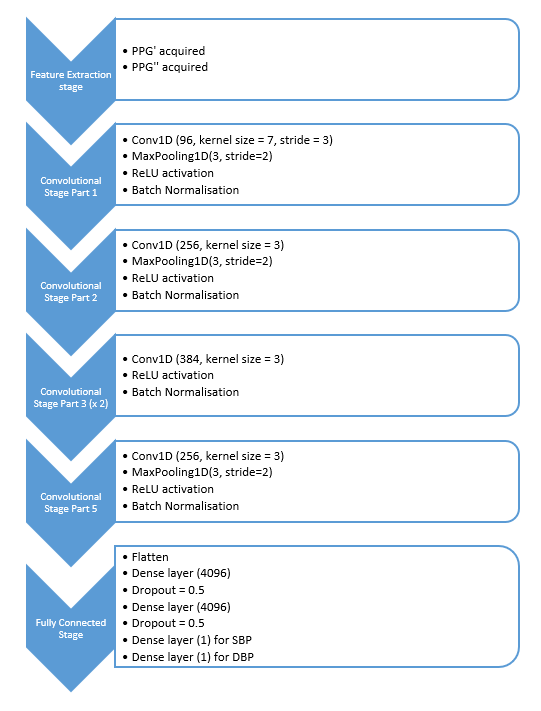

In [3]:
from IPython.display import Image
display(Image('/content/FinalYearProject---BP-from-PPG/models/alexnetArch.png'))

In [ ]:
"""
This code cell performs the following tasks:

-----> Implements an AlexNet Conv-Net which performs HR, SBP and DBP regression based on spectrograms
----->  The net's input are ppg time series.

The following input arguments are required:

-----> data_in : Tensor containing the rppg time series. Size (batch_size, ppg_length, 1)
-----> fs : sampling frequency (default fs = 125 Hz)
-----> frame_len : length of the STFFT in seconds (default frame_len = 10)
-----> n_hop : length between frames during spectrogram calculation in samples (default n_hop = 1)
"""

from tensorflow.keras.layers import Softmax, Permute, Input, Add, Conv1D, MaxPooling1D, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling1D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU, GlobalAveragePooling2D, ReLU, Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
import tensorflow as tf
import scipy

def AlexNet_1D(data_in_shape, num_output=2, dil=1, kernel_size=3, fs = 125, useMaxPooling=True, UseDerivative=False):

    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=data_in_shape)

    if UseDerivative:
        dt1 = (X_input[:,1:] - X_input[:,:-1])*fs
        dt2 = (dt1[:,1:] - dt1[:,:-1])*fs
        dt1 = tf.pad(dt1, tf.constant([[0,0],[0,1],[0,0]]))
        dt2 = tf.pad(dt2, tf.constant([[0,0],[0,2],[0,0]]))
        X = tf.concat([X_input, dt1, dt2], axis=2)
    else:
        X=X_input


    # convolutional stage
    X = Conv1D(96, 7, strides=3, name='conv1', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    if useMaxPooling:
        X = MaxPooling1D(3, strides=2, name="MaxPool1")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm1')(X)

    X = Conv1D(256, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv2', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    if useMaxPooling:
        X = MaxPooling1D(3, strides=2, name="MaxPool2")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm2')(X)

    X = Conv1D(384, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv3', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm3')(X)

    X = Conv1D(384, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv4', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm4')(X)

    X = Conv1D(256, kernel_size=kernel_size, strides=1, dilation_rate=dil, name='conv5', kernel_initializer=glorot_uniform(seed=0), padding="same")(X)
    if useMaxPooling:
        X = MaxPooling1D(3, strides=2, name="MaxPool5")(X)
    X = Activation(ReLU())(X)
    X = BatchNormalization(axis=-1, name='BatchNorm5')(X)

    # Fully connected stage
    X = Flatten()(X)
    X = Dense(4096, activation='relu', name='dense1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(rate=0.5)(X)
    X = Dense(4096, activation='relu', name='dense2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(rate=0.5)(X)

    # Create model
    if num_output == 1:
        X_out = Dense(3, activation='softmax', name='out', kernel_initializer=glorot_uniform(seed=0))(X)
        model = Model(inputs=X_input, outputs=X_out, name='AlexNet_1D')
    else:
        # output stage
        X_SBP = Dense(1, activation='relu', name='SBP', kernel_initializer=glorot_uniform(seed=0))(X)
        X_DBP = Dense(1, activation='relu', name='DBP', kernel_initializer=glorot_uniform(seed=0))(X)
        model = Model(inputs=X_input, outputs=[X_SBP, X_DBP], name='AlexNet_1D')

    return model

## ResNet

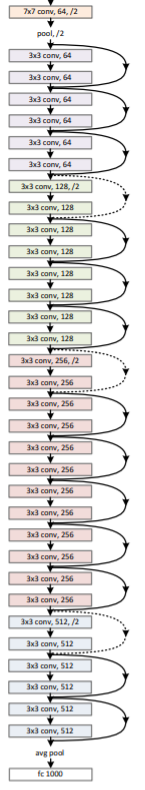

In [4]:
from IPython.display import Image
display(Image('/content/FinalYearProject---BP-from-PPG/models/resnetArch.png'))

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling2D, LeakyReLU, GlobalAveragePooling2D, ReLU, concatenate
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.models import Model
import tensorflow as tf


def identity_block(X, f, filters, stage, block, dil=1):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, dilation_rate=dil, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2a')(X)
    X = Activation(ReLU())(X)

    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, dilation_rate=dil, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum=0.9, name=bn_name_base + '2b')(X)
    X = Activation(ReLU())(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, dilation_rate=dil, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation(ReLU())(X)
    # X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2, dil = 1):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum=0.9, name=bn_name_base + '2a')(X)
    X = Activation(ReLU())(X)
    
    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, dilation_rate=dil, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum=0.9, name=bn_name_base + '2b')(X)
    X = Activation(ReLU())(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, dilation_rate=dil, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(filters = F3, kernel_size = 1, strides = s, padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization( momentum = 0.9, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation(ReLU())(X)
    # X = BatchNormalization(momentum = 0.9, name = bn_name_base + '2c')(X)
    
    return X

def ResNet50_1D(data_in_shape, num_output=2, fs=125, UseDerivative=False):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=data_in_shape)

    if UseDerivative:
        dt1 = (X_input[:,1:] - X_input[:,:-1])*fs
        dt2 = (dt1[:,1:] - dt1[:,:-1])*fs

        dt1 = tf.pad(dt1, tf.constant([[0,0],[0,1],[0,0]]))
        dt2 = tf.pad(dt2, tf.constant([[0,0],[0,2],[0,0]]))

        X = tf.concat([X_input, dt1, dt2], axis=2)
    else:
        X=X_input

    # Zero-Padding
    X = ZeroPadding1D(3)(X_input)

    # Stage 1
    X = Conv1D(64, 7, strides=2, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=3)(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling1D(2, name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X_SBP = Dense(1, activation='linear', name='SBP', kernel_initializer = glorot_uniform(seed=0))(X)
    X_DBP = Dense(1, activation='linear', name='DBP', kernel_initializer = glorot_uniform(seed=0))(X)
    HR = Dense(1, activation='linear', name='HR', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    if num_output==3:
        model = Model(inputs=X_input, outputs=[X_SBP, X_DBP, HR], name='ResNet50_1D')
    else:
        model = Model(inputs = X_input, outputs = [X_SBP, X_DBP], name='ResNet50_1D')

    return model

## Slapnicar

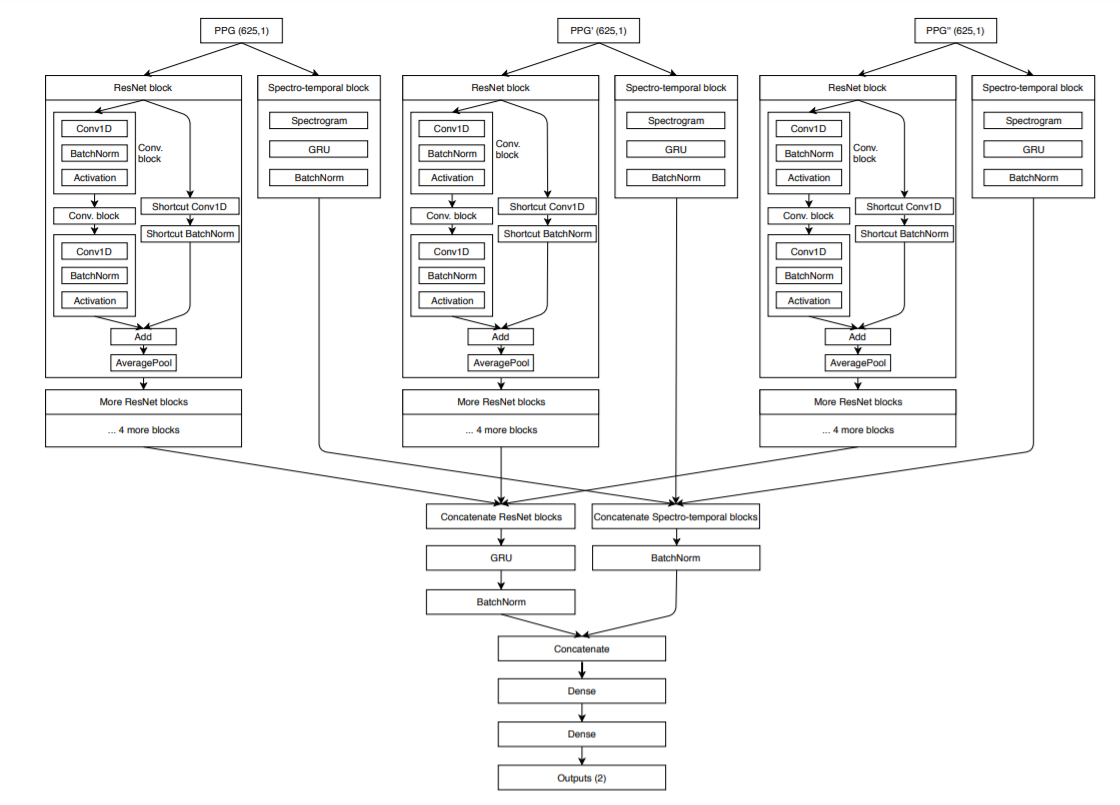

In [5]:
from IPython.display import Image
display(Image('/content/FinalYearProject---BP-from-PPG/models/slapnicarArch.png'))

In [ ]:
from __future__ import division, print_function
import numpy as np
np.random.seed(3)
import os

from scipy.signal import butter, lfilter, lfilter_zi, filtfilt, savgol_filter
from sklearn.preprocessing import MinMaxScaler
import sklearn as sk
import random
random.seed(3)

import scipy.io as sio
import matplotlib.pyplot as plt
import natsort as natsort
from scipy import signal
import math

import tensorflow as tf
# from tensorflow.keras.utils import multi_gpu_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import squeeze
from kapre import STFT, Magnitude, MagnitudeToDecibel
# from kapre.utils import Normalization2D
from tensorflow.keras.layers import Input, BatchNormalization, Lambda, AveragePooling2D, Flatten, Dense, Conv1D, Activation, add, AveragePooling1D, Dropout, Permute, concatenate, MaxPooling1D, LSTM, Reshape, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras import optimizers
#from tensorflow.keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Conv2D, MaxPooling2D

def diff(input, fs):
    dt = (input[:, 1:] - input[:, :-1]) * fs
    dt = tf.pad(dt, tf.constant([[0, 0], [0, 1], [0, 0]]))

    return dt

def mid_spectrogram_layer(input_x):
    l2_lambda = .001
    n_dft = 128
    n_hop = 64
    fmin = 0.0
    fmax = 50 / 2

    x = Permute((2, 1))(input_x)
    # x = input_x
    x = STFT(n_fft=n_dft, hop_length=n_hop, output_data_format='channels_last')(x)
    x = Magnitude()(x)
    #x = MagnitudeToDecibel()(x)
    #x = BatchNormalization()(x)
    # x = Normalization2D(str_axis='batch')(x)
    x = Flatten()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)

    return x


def mid_spectrogram_LSTM_layer(input_x):
    l2_lambda = .001
    n_dft = 64

    n_hop = 64
    fmin = 0.0
    fmax = 50 / 2

    #x = Permute((2, 1))(input_x)
    x = input_x
    x = STFT(n_fft=n_dft, hop_length=n_hop, output_data_format='channels_last')(x)
    x = Magnitude()(x)
    x = MagnitudeToDecibel()(x)
   #x = BatchNormalization()(x)
    # x = Normalization2D(str_axis='batch')(x)
    # print(np.array(x).shape)
    # x = Reshape((2, 64))(x)
    # x = GRU(64)(x)
    x = Flatten()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)

    return x


def single_channel_resnet(my_input, num_filters=64, num_res_blocks=4, cnn_per_res=3,
                          kernel_sizes=[8, 5, 3], max_filters=128, pool_size=3, pool_stride_size=2):

    #my_input = Input(shape=input_shape)
    # my_input = input_shape
    # my_input = ks.expand_dims(my_input, axis=2)

    for i in np.arange(num_res_blocks):
        if (i == 0):
            block_input = my_input
            x = BatchNormalization()(block_input)
        else:
            block_input = x

        for j in np.arange(cnn_per_res):
            x = Conv1D(num_filters, kernel_sizes[j], padding='same')(x)
            x = BatchNormalization()(x)
            if (j < cnn_per_res - 1):
                x = Activation('relu')(x)

        is_expand_channels = not (my_input.shape[0] == num_filters)

        if is_expand_channels:
            res_conn = Conv1D(num_filters, 1, padding='same')(block_input)
            res_conn = BatchNormalization()(res_conn)
        else:
            res_conn = BatchNormalization()(block_input)

        x = add([res_conn, x])
        x = Activation('relu')(x)

        if (i < 5):
            x = AveragePooling1D(pool_size=pool_size, strides=pool_stride_size)(x)

        num_filters = 2 * num_filters
        if max_filters < num_filters:
            num_filters = max_filters

    return my_input, x


def raw_signals_deep_ResNet(input, UseDerivative=False):
    fs=125

    inputs = []
    l2_lambda = .001
    channel_outputs = []
    num_filters = 32

    X_input = Input(shape=input)

    if UseDerivative:
        # fs = tf.constant(fs, dtype=float)
        X_dt1 = Lambda(diff, arguments={'fs': fs})(X_input)
        X_dt2 = Lambda(diff, arguments={'fs': fs})(X_dt1)
        X = [X_input, X_dt1, X_dt2]
    else:
        X = [X_input]

    num_channels = len(X)

    for i in np.arange(num_channels):
        channel_resnet_input, channel_resnet_out = single_channel_resnet(X[i], num_filters=num_filters,
                                                                     num_res_blocks=4, cnn_per_res=3,
                                                                     kernel_sizes=[8, 5, 5, 3],
                                                                     max_filters=64, pool_size=2, pool_stride_size=1)
        channel_outputs.append(channel_resnet_out)
        inputs.append(channel_resnet_input)

    spectral_outputs = []
    num_filters = 32
    for x in inputs:
        spectro_x = mid_spectrogram_LSTM_layer(x)
        spectral_outputs.append(spectro_x)

    # concatenate the channel specific residual layers

    # print("Num Channels: ", num_channels)

    if num_channels > 1:
        x = concatenate(channel_outputs, axis=-1)
    else:
        x = channel_outputs[0]

    x = BatchNormalization()(x)
    x = GRU(65)(x)
    # x = Flatten()(x)
    x = BatchNormalization()(x)

    # join time-domain and frequnecy domain fully-conencted layers
    if num_channels > 1:
        s = concatenate(spectral_outputs, axis=-1)
    else:
        s = spectral_outputs[0]

    # s = Flatten()(s)
    #     x = Dense(128,activation="relu",kernel_regularizer=l2(l2_lambda)) (x)
    s = BatchNormalization()(s)
    # LETS DO OVERFIT
    x = concatenate([s, x])
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.25)(x)
    #output = Dense(2, activation="relu")(x)
    x = Flatten()(x)
    X_SBP = Dense(1, activation='linear', name='SBP')(x)
    X_DBP = Dense(1, activation='linear', name='DBP')(x)

    model = Model(inputs=X_input, outputs=[X_SBP, X_DBP], name="Slapnicar_Model")
    # model = multi_gpu_model(model, gpus=2)
    # optimizer = optimizers.Adadelta()
    # loss = ks.keras.losses.mean_absolute_error
    # model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mae'])
    print(model.summary())
    # plot_model(model=model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
    return model


def one_chennel_resnet(input_shape,num_filters=16,num_res_blocks = 5,cnn_per_res = 3,
                        kernel_sizes = [3,3,3], max_filters = 64, pool_size = 3,
                        pool_stride_size = 2,num_classes=8):
    my_input  = Input(shape=(input_shape))
    for i in np.arange(num_res_blocks):
        if(i==0):
            block_input = my_input
            x = BatchNormalization()(block_input)
        else:
            block_input = x
        for j in np.arange(cnn_per_res):
            x = Conv1D(num_filters, kernel_sizes[j], padding='same')(x)
            x = BatchNormalization()(x)
            if(j<cnn_per_res-1):
                x = Activation('relu')(x)
        is_expand_channels = not (input_shape[0] == num_filters)
        if is_expand_channels:
            res_conn = Conv1D(num_filters, 1,padding='same')(block_input)
            res_conn = BatchNormalization()(res_conn)
        else:
            res_conn = BatchNormalization()(block_input)
        x = add([res_conn, x])
        x = Activation('relu')(x)
        if(i<5):
            x = MaxPooling1D(pool_size=pool_size,strides =pool_stride_size)(x)
        num_filters = 2*num_filters
        if max_filters<num_filters:
            num_filters = max_filters
    return my_input,x


def one_chennel_resnet_2D(input_shape, input_layer, num_filters=16,num_res_blocks = 5,cnn_per_res = 3,
                        kernel_sizes = [8, 5, 3], max_filters = 64, pool_size = (3,3),
                        pool_stride_size = 2, num_classes=8):
    kernel_sizes = [(8, 1), (5, 1), (3, 1)]
    my_input = input_layer
    for i in np.arange(num_res_blocks):
        if(i==0):
            block_input = my_input
            x = BatchNormalization()(block_input)
        else:
            block_input = x
        for j in np.arange(cnn_per_res):
            x = Conv2D(num_filters, kernel_sizes[j], padding='same')(x)
            x = BatchNormalization()(x)
            if(j<cnn_per_res-1):
                x = Activation('relu')(x)
        is_expand_channels = not (input_shape[0] == num_filters)
        if is_expand_channels:
            res_conn = Conv2D(num_filters, (1,1), padding='same')(block_input)
            res_conn = BatchNormalization()(res_conn)
        else:
            res_conn = BatchNormalization()(block_input)
        x = add([res_conn, x])
        x = Activation('relu')(x)
        if(i<5):
            x = MaxPooling2D(pool_size=pool_size,strides =pool_stride_size)(x)
        num_filters = 2*num_filters
        if max_filters<num_filters:
            num_filters = max_filters
    return my_input,x


def spectro_layer_mid(input_x,sampling_rate, ndft=0, num_classes=8):
    l2_lambda = .001
    if(ndft == 0):
        n_dft= 128
    else:
        n_dft = ndft
    # n_dft = 64
    n_hop = 64
    fmin=0.0
    fmax=sampling_rate//2

    x = Permute((2,1))(input_x)
    x = STFT(n_fft=n_dft, hop_length=n_hop, output_data_format='channels_last')(x)
    x = Magnitude()(x)
    #x = MagnitudeToDecibel()(x)
    #x = BatchNormalization()(x)    # x = Normalization2D(str_axis='batch')(x)
    channel_resnet_input,channel_resnet_out= one_chennel_resnet_2D((625, 1), x, num_filters=64,
                    num_res_blocks = 6,cnn_per_res = 3,kernel_sizes = [3,3,3,3],
                    max_filters = 32, pool_size = 1,
                    pool_stride_size =1,num_classes=8)
    channel_resnet_out = BatchNormalization()(channel_resnet_out)

    # x = Reshape((10, 65))(x)
    # x = GRU(65)(x)

    return channel_resnet_out

## Long Short Term Memory (LSTM)

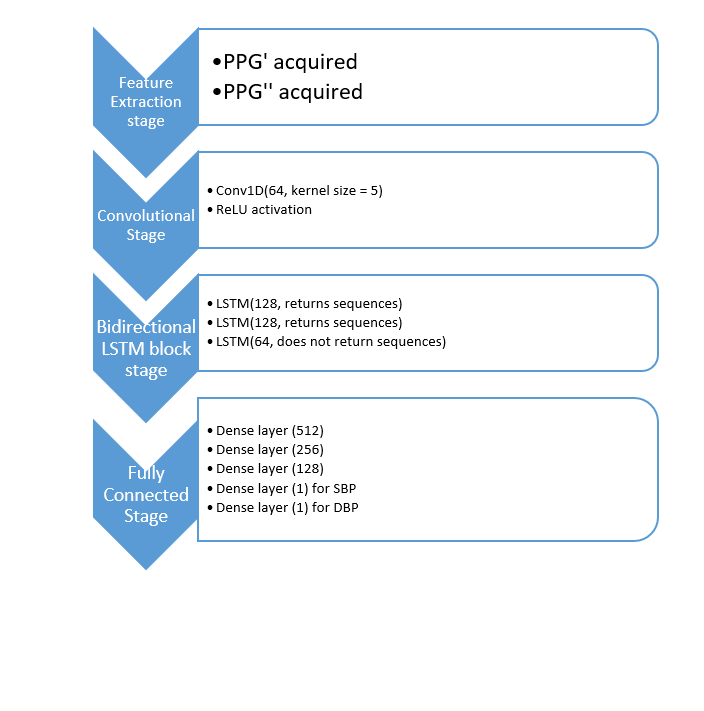

In [6]:
from IPython.display import Image
display(Image('/content/FinalYearProject---BP-from-PPG/models/lstmArch.png'))

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Conv1D, ReLU

from tensorflow.keras import Model

def define_LSTM(data_in_shape, UseDerivative=False):
    X_input = Input(shape=data_in_shape)

    fs = 125

    if UseDerivative:
        dt1 = (X_input[:,1:] - X_input[:,:-1])*fs
        dt2 = (dt1[:,1:] - dt1[:,:-1])*fs

        dt1 = tf.pad(dt1, tf.constant([[0,0],[0,1],[0,0]]))
        dt2 = tf.pad(dt2, tf.constant([[0,0],[0,2],[0,0]]))

        X = tf.concat([X_input, dt1, dt2], axis=2)
    else:
        X=X_input


    X = Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu')(X)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = Bidirectional(LSTM(64, return_sequences=False))(X)
    X = Dense(512, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(128, activation='relu')(X)

    X_SBP = Dense(1, name='SBP')(X)
    X_DBP = Dense(1, name='DBP')(X)

    model = Model(inputs=X_input, outputs=[X_SBP, X_DBP], name='LSTM')

    return model

## Transformer Encoder (Attention)

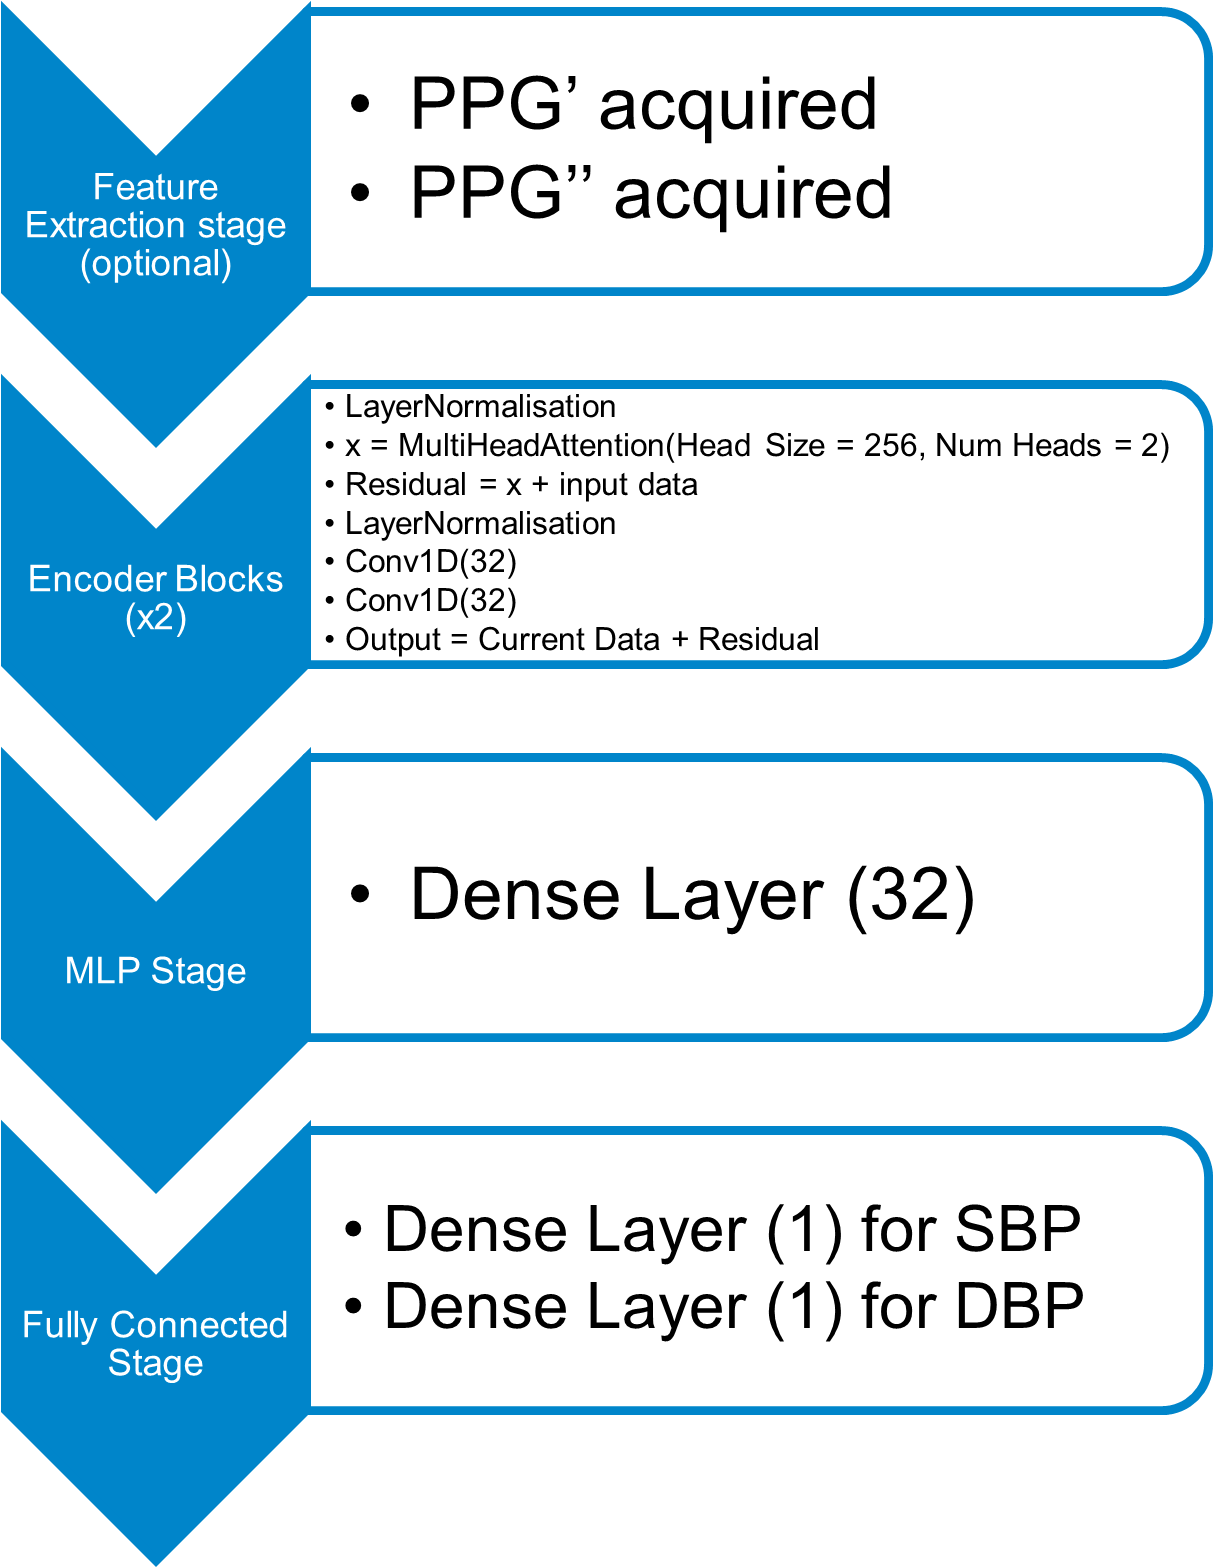

In [7]:
from IPython.display import Image
display(Image('/content/FinalYearProject---BP-from-PPG/models/transformerArch.png'))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def define_encoder(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    UseDerivative=False
):
    inputs = keras.Input(shape=input_shape)
    X_input = inputs
    fs = 125

    if UseDerivative:
        dt1 = (X_input[:,1:] - X_input[:,:-1])*fs
        dt2 = (dt1[:,1:] - dt1[:,:-1])*fs

        dt1 = tf.pad(dt1, tf.constant([[0,0],[0,1],[0,0]]))
        dt2 = tf.pad(dt2, tf.constant([[0,0],[0,2],[0,0]]))

        x = tf.concat([X_input, dt1, dt2], axis=2)
    else:
        x=X_input

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # outputs = layers.Dense(1)(x)

    X_SBP = layers.Dense(1, name='SBP')(x)
    X_DBP = layers.Dense(1, name='DBP')(x)

    model = Model(inputs=inputs, outputs=[X_SBP, X_DBP], name='Encoder')
    # return keras.Model(inputs, outputs)
    tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

    return model

# Function to training on PPG data

In [ ]:
"""
This code cell performs the following tasks:

-----> Trains neural network architectures using PPG data
-----> The data is loaded from the the .tfrecord files created by the 'Converting from .h5 to Tensorflow format' code cell

-----> Five different neural architectures can be selected:

    -----> AlexNet
    -----> ResNet
    -----> Spectrotemporal ResNet
    -----> LSTM network
    -----> Transformer Encoder

-----> A checkpoint callback is used to store the best network weights in terms of validation loss

-----> These weights are subsequently used to perform predictions on the test dataset

-----> The test results are stored in a .csv file for later evaluation
"""

from os.path import expanduser, join
from os import environ
from functools import partial
from datetime import datetime

import tensorflow as tf
import pandas as pd
import numpy as np
import time

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

def read_tfrecord(example, win_len):
    tfrecord_format = (
        {
            'ppg': tf.io.FixedLenFeature([win_len], tf.float32),
            'label': tf.io.FixedLenFeature([2], tf.float32)
        }
    )
    parsed_features = tf.io.parse_single_example(example, tfrecord_format)

    return parsed_features['ppg'], (parsed_features['label'][0], parsed_features['label'][1])

def create_dataset(tfrecords_dir, tfrecord_basename, epochs, win_len, batch_size, modus='train'):

    pattern = join(tfrecords_dir, modus, tfrecord_basename + "_" + modus + "_?????_of_?????.tfrecord")
    dataset = tf.data.TFRecordDataset.list_files(pattern)

    if modus == 'train':
        dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
        dataset = dataset.interleave(
            tf.data.TFRecordDataset,
            cycle_length=800,
            block_length=400)
    else:
        dataset = dataset.interleave(
            tf.data.TFRecordDataset)

    dataset = dataset.map(partial(read_tfrecord, win_len=win_len), num_parallel_calls=2)
    dataset = dataset.shuffle(4096, reshuffle_each_iteration=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.repeat(epochs)

    return dataset

def get_model(architecture, input_shape, UseDerivative=False):
  if architecture == 'alexnet':
    return AlexNet_1D(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'resnet':
    return ResNet50_1D(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'slapnicar':
    return raw_signals_deep_ResNet(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'lstm':
    return define_LSTM(input_shape, UseDerivative=UseDerivative)
  elif architecture == 'encoder':
    return define_encoder(input_shape, head_size=256, num_heads=2, ff_dim=32, num_transformer_blocks=2, mlp_units=[32], mlp_dropout=0, dropout=0, UseDerivative=UseDerivative)

def ppg_train_mimic(architecture,
                        DataDir,
                        ResultsDir,
                        CheckpointDir,
                        tensorboard_tag,
                        tfrecord_basename,
                        experiment_name,
                        win_len,
                        batch_size,
                        lr,
                        N_epochs,
                        Ntrain,
                        Nval,
                        Ntest,
                        UseDerivative=False,
                        earlystopping=False):

    # create datasets for training, validation and testing using .tfrecord files
    test_dataset = create_dataset(DataDir, tfrecord_basename, N_epochs, win_len=win_len, batch_size=batch_size,
                                  modus='test')
    train_dataset = create_dataset(DataDir, tfrecord_basename, N_epochs, win_len=win_len, batch_size=batch_size, modus='train')
    val_dataset = create_dataset(DataDir, tfrecord_basename, N_epochs, win_len=win_len, batch_size=batch_size,
                                 modus='val')

    data_in_shape = (win_len,1)

    # load the neurarchitecture
    model = get_model(architecture, data_in_shape, UseDerivative=UseDerivative)

    model.summary()

    # callback for logging training and validation results
    csvLogger_cb = tf.keras.callbacks.CSVLogger(
        filename=join(ResultsDir,experiment_name + '_learningcurve.csv')
    )

    # checkpoint callback
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=join(CheckpointDir , experiment_name + '_cb.h5'),
        save_best_only=True
    )

    # tensorboard callback
    tensorbard_cb = tf.keras.callbacks.TensorBoard(
        log_dir=join(ResultsDir, 'tb', tensorboard_tag),
        histogram_freq=0,
        write_graph=False
    )

    # callback for early stopping if validation loss stops improving
    EarlyStopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # define Adam optimizer
    if lr is None:
        opt = tf.keras.optimizers.Adam()
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # compile model using mean squared error as loss function
    model.compile(
        optimizer=opt,
        loss = tf.keras.losses.mean_squared_error,
        metrics = [['mae'], ['mae']]
    )
    
    if earlystopping == True:
      ES = EarlyStopping_cb
    else:
      ES = []

    cb_list = [checkpoint_cb, tensorbard_cb, csvLogger_cb, ES]

    n,line_batch = next(iter(train_dataset))
    print(n.numpy())

    # Perform Training and Validation

    history = model.fit(
        train_dataset,
        batch_size = batch_size,
        steps_per_epoch=Ntrain//batch_size,
        epochs=N_epochs,
        validation_data=val_dataset,
        validation_steps=Nval//batch_size,
        callbacks=cb_list
    )
#
    # Predictions on the testset
    model.load_weights(checkpoint_cb.filepath)
    test_results = pd.DataFrame({'SBP_true' : [],
                                 'DBP_true' : [],
                                 'SBP_est' : [],
                                 'DBP_est' : []})

    # store predictions on the test set as well as the corresponding ground truth in a csv file
    test_dataset = iter(test_dataset)
    inf = []
    for i in range(int(Ntest//batch_size)):
        ppg_test, BP_true = test_dataset.next()


        start_time = time.time()
        BP_est = model.predict(ppg_test)
        time_elapsed = time.time() - start_time
        print('Test loss:', BP_est[0])
        print('Test accuracy:', BP_est[1])
        print('Average inference time per test sample: {:.4f} (ms)'.format(1000*time_elapsed/len(ppg_test)))
        inf.append(1000*time_elapsed/len(ppg_test))

        TestBatchResult = pd.DataFrame({'SBP_true' : BP_true[0].numpy(),
                                        'DBP_true' : BP_true[1].numpy(),
                                        'SBP_est' : np.squeeze(BP_est[0]),
                                        'DBP_est' : np.squeeze(BP_est[1])})
        test_results = test_results.append(TestBatchResult)

    ResultsFile = join(ResultsDir,experiment_name + '_test_results.csv')
    test_results.to_csv(ResultsFile)
    print('Mean overall inference time (ms): ', np.mean(inf))
    idx_min = np.argmin(history.history['val_loss'])

    fig, axes = plt.subplots(2,2, figsize=(20,20))
    axes[0,0].plot(history.history['SBP_mae'])
    axes[0,0].set_title('SBP MAE')
    axes[0,0].set_ylabel('MAE (mmHg)')
    axes[0,0].set_xlabel('Epoch (A.U)')

    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    axes[0,1].plot(history.history['DBP_mae'])
    axes[0,1].set_title('DBP MAE')
    axes[0,1].set_ylabel('MAE (mmHg)')
    axes[0,1].set_xlabel('Epoch (A.U)')

    axes[1,0].plot(history.history['val_SBP_mae'])
    axes[1,0].set_title('VAL SBP MAE')
    axes[1,0].set_ylabel('MAE (mmHg)')
    axes[1,0].set_xlabel('Epoch (A.U)')

    axes[1,1].plot(history.history['val_DBP_mae'])
    axes[1,1].set_title('VAL DBP MAE')
    axes[1,1].set_ylabel('MAE (mmHg)')
    axes[1,1].set_xlabel('Epoch (A.U)')
    print(' Training finished')

    return history.history['SBP_mae'][idx_min], history.history['DBP_mae'][idx_min], history.history['val_SBP_mae'][idx_min], history.history['val_DBP_mae'][idx_min]

# Training (AlexNet)

In [ ]:
!mkdir /content/FilesCP

architecture = "alexnet"
experiment_name = 'test'
experiment_name = datetime.now().strftime("%Y-%d-%m") + '_' + architecture + '_' + experiment_name
DataDir = '/content/drive/MyDrive/Colab Notebooks/tfRec'
ResultsDir = '/content/drive/MyDrive/Colab Notebooks/FilesTrainedFinal'
CheckpointDir = '/content/FilesCP'
tb_tag = experiment_name
lr = 0.005
batch_size = 128
win_len = 1*125
N_epochs = 100

tfrecord_basename = 'MIMIC_ppg'

ppg_train_mimic(architecture,
                    DataDir,
                    ResultsDir,
                    CheckpointDir,
                    tb_tag,
                    tfrecord_basename,
                    experiment_name,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    Ntrain=numTraining,
                    Nval=numValidation,
                    Ntest=numTest,
                    UseDerivative=True,
                    earlystopping=False)

# Training (ResNet)

In [ ]:
!mkdir /content/FilesCP2

architecture = "resnet"
experiment_name = 'test2'
experiment_name = datetime.now().strftime("%Y-%d-%m") + '_' + architecture + '_' + experiment_name
DataDir = '/content/drive/MyDrive/Colab Notebooks/tfRec'  # tfRecFinal
ResultsDir = '/content/drive/MyDrive/Colab Notebooks/FilesTrainedFinal' # FilesMLTrained
CheckpointDir = '/content/FilesCP2'
tb_tag = experiment_name
lr = 0.005
batch_size = 128
win_len = 1*125
N_epochs = 100

tfrecord_basename = 'MIMIC_ppg'

ppg_train_mimic(architecture,
                    DataDir,
                    ResultsDir,
                    CheckpointDir,
                    tb_tag,
                    tfrecord_basename,
                    experiment_name,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    Ntrain=numTraining,
                    Nval=numValidation,
                    Ntest=numTest,
                    UseDerivative=True,
                    earlystopping=False)

# Training (Slapnicar)

In [ ]:
!mkdir /content/FilesCP3

architecture = "slapnicar"
experiment_name = 'test3'
experiment_name = datetime.now().strftime("%Y-%d-%m") + '_' + architecture + '_' + experiment_name
DataDir = '/content/drive/MyDrive/Colab Notebooks/tfRec'  # tfRecFinal
ResultsDir = '/content/drive/MyDrive/Colab Notebooks/FilesTrainedFinal' # FilesMLTrained
CheckpointDir = '/content/FilesCP3'
tb_tag = experiment_name
lr = 0.005
batch_size = 128
win_len = 1*125
N_epochs = 100

tfrecord_basename = 'MIMIC_ppg'

ppg_train_mimic(architecture,
                    DataDir,
                    ResultsDir,
                    CheckpointDir,
                    tb_tag,
                    tfrecord_basename,
                    experiment_name,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    Ntrain=numTraining,
                    Nval=numValidation,
                    Ntest=numTest,
                    UseDerivative=True,
                    earlystopping=False)

# Training (LSTM)

In [ ]:
!mkdir /content/FilesCP4

architecture = "lstm"
experiment_name = 'test4'
experiment_name = datetime.now().strftime("%Y-%d-%m") + '_' + architecture + '_' + experiment_name
DataDir = '/content/drive/MyDrive/Colab Notebooks/tfRec'  # tfRecFinal
ResultsDir = '/content/drive/MyDrive/Colab Notebooks/FilesTrainedFinal' # FilesMLTrained
CheckpointDir = '/content/FilesCP4'
tb_tag = experiment_name
lr = 0.005
batch_size = 128
win_len = 1*125
N_epochs = 100

tfrecord_basename = 'MIMIC_ppg'

ppg_train_mimic(architecture,
                    DataDir,
                    ResultsDir,
                    CheckpointDir,
                    tb_tag,
                    tfrecord_basename,
                    experiment_name,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    Ntrain=numTraining,
                    Nval=numValidation,
                    Ntest=numTest,
                    UseDerivative=True,
                    earlystopping=False)

# Training (Encoder)

Streaming output truncated to the last 5000 lines.
 [50.84144 ]
 [48.844887]
 [57.26494 ]
 [48.947655]
 [54.349075]
 [46.968704]
 [48.922802]
 [48.978443]
 [49.443226]
 [52.953426]
 [50.108154]
 [52.165997]
 [57.297024]
 [43.430737]
 [48.471367]
 [48.482235]
 [52.308662]
 [45.928703]
 [54.080166]
 [55.335358]
 [57.492764]
 [47.371372]
 [46.790653]
 [49.95091 ]
 [54.40293 ]
 [55.920403]
 [51.389107]
 [50.40476 ]
 [49.872627]
 [53.12875 ]
 [45.98905 ]
 [48.107414]
 [48.854286]
 [51.722923]
 [51.460335]
 [47.70246 ]
 [53.561428]
 [50.256313]
 [48.736763]
 [51.38772 ]
 [48.927437]
 [52.792824]
 [54.641743]
 [54.58218 ]
 [50.853992]
 [46.650124]
 [50.763615]
 [49.990852]
 [48.50658 ]
 [50.694344]
 [54.47761 ]
 [48.77402 ]
 [51.82568 ]
 [52.34856 ]
 [47.791576]
 [47.45169 ]
 [46.807884]
 [63.021   ]
 [53.747875]
 [41.868053]
 [52.37117 ]
 [48.02279 ]
 [49.84701 ]
 [44.85765 ]
 [47.504402]
 [52.681194]
 [48.732334]
 [50.54927 ]
 [59.027855]
 [50.892178]
 [47.184025]
 [52.415222]
 [49.046574]


(12.97805404663086, 6.201530456542969, 12.76911735534668, 5.495184898376465)

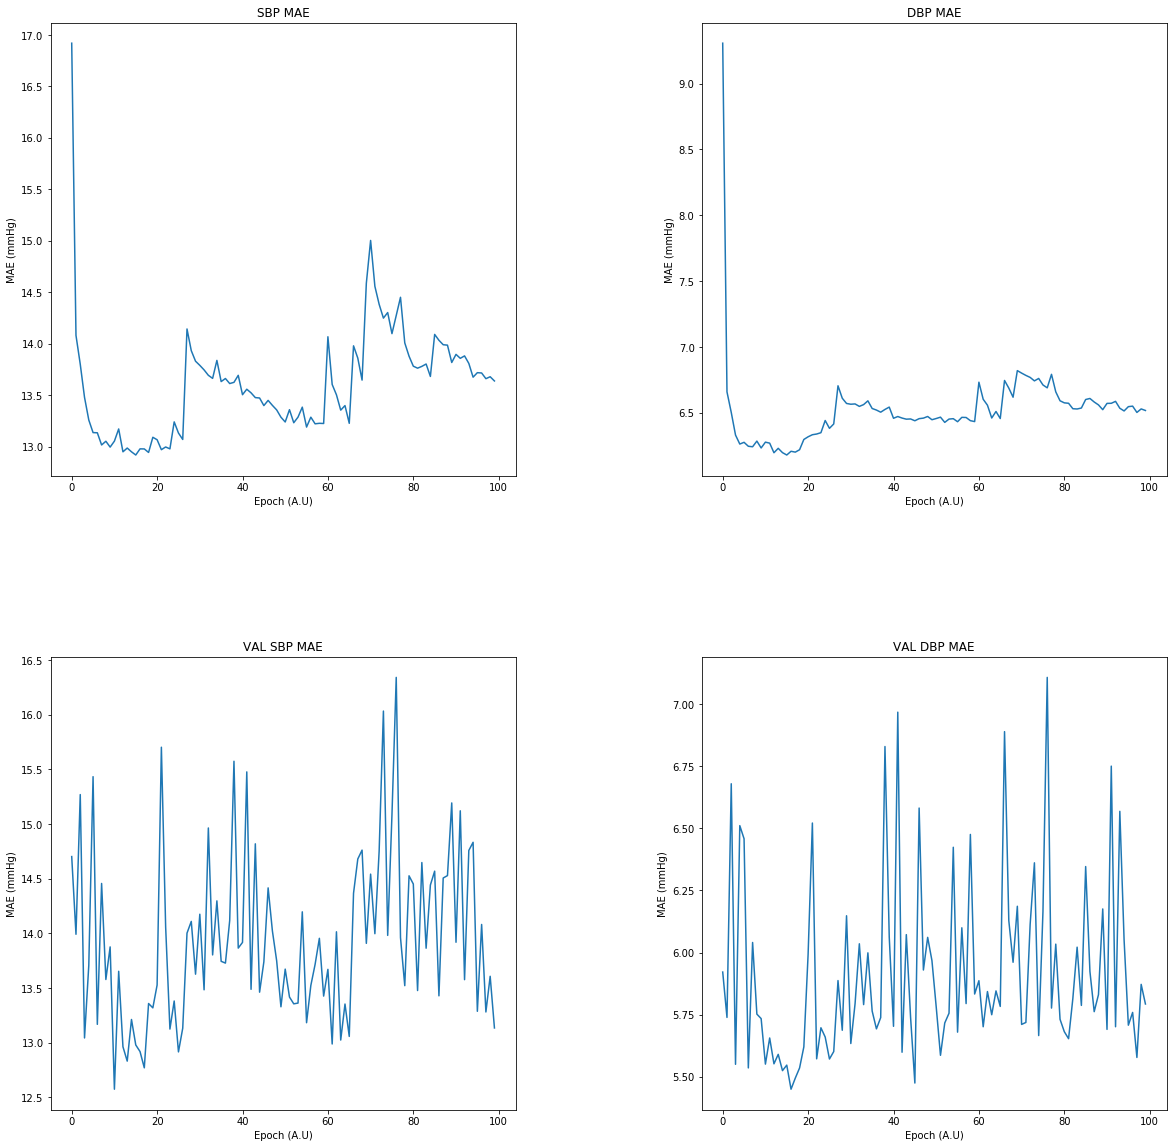

In [ ]:
!mkdir /content/FilesCP5

architecture = "encoder"
experiment_name = 'test5'
experiment_name = datetime.now().strftime("%Y-%d-%m") + '_' + architecture + '_' + experiment_name
DataDir = '/content/drive/MyDrive/Colab Notebooks/tfRec'  # tfRecFinal
ResultsDir = '/content/drive/MyDrive/Colab Notebooks/FilesTrainedFinal' # FilesMLTrained
CheckpointDir = '/content/FilesCP5'
tb_tag = experiment_name
lr = 0.005
batch_size = 128
win_len = 1*125
N_epochs = 100

tfrecord_basename = 'MIMIC_ppg'

ppg_train_mimic(architecture,
                    DataDir,
                    ResultsDir,
                    CheckpointDir,
                    tb_tag,
                    tfrecord_basename,
                    experiment_name,
                    win_len=win_len,
                    batch_size=batch_size,
                    lr=lr,
                    N_epochs=N_epochs,
                    Ntrain=numTraining,
                    Nval=numValidation,
                    Ntest=numTest,
                    UseDerivative=True,
                    earlystopping=False)